In [1]:
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

In [2]:
positive_samples = load_positive_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:40<00:00,  1.42it/s]


In [3]:
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  3.46it/s]


In [4]:
def plot_img(samples, select_num=6):   
    num_samples = len(samples)
    selected_index = np.random.choice(num_samples, select_num, replace=True)
    
    count = 0
    for index in selected_index:
        count += 1     
        plt_idx = count
        plt.subplot(1, select_num, plt_idx)
        plt.imshow(samples[index])
        plt.axis('off')
        
    plt.show()

23919


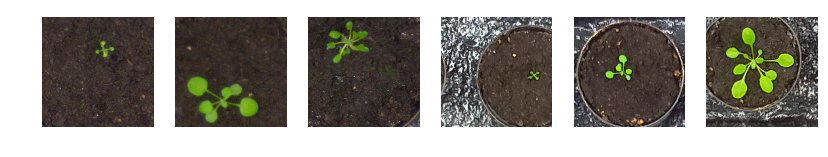

In [10]:
print(len(positive_samples))
plot_img(positive_samples)

15311


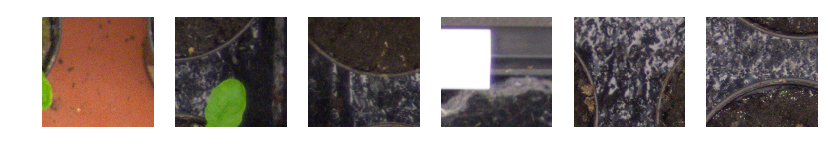

In [11]:
print(len(negative_samples))
plot_img(negative_samples)

In [12]:
def Hog_feature(img):
    orientations = 9
    pixels_per_cell = [5, 5]
    cells_per_block = [3, 3]
    visualize = False
    normalize = True
    
    im=Image.fromarray(img)
    im=im.convert('L')
    
    fd = hog(im, orientations, 
         pixels_per_cell, cells_per_block, 
         visualize, normalize)
    
    return fd

In [13]:
positive_fds= []
for img in tqdm(positive_samples):
    positive_fds.append(Hog_feature(img))

  6%|████████▊                                                                                                                                            | 1412/23919 [00:36<09:52, 37.97it/s]

KeyboardInterrupt: 

In [15]:
negative_fds= []
sample_indexes = np.random.choice(len(negative_samples), 6000, replace=False)
for idx in tqdm(sample_indexes):
    negative_fds.append(Hog_feature(negative_samples[idx]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:10<00:00, 84.92it/s]


In [16]:
from sklearn.model_selection import train_test_split

labels = []
fds = []
for sample in positive_fds:
    fds.append(sample)
    labels.append([1, 0])
    
for sample in negative_fds:
    fds.append(sample)
    labels.append([0, 1])

del positive_fds
del negative_fds
del positive_samples
del negative_samples


X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.4, random_state=0)

In [17]:
from svm_model import svm

model = svm(input_size=63504)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=20, verbose=1, 
                callbacks=None, validation_split=0.2, validation_data=None, 
                shuffle=True, initial_epoch=0)

Using TensorFlow backend.


SVM model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 127010    
Total params: 127,010.0
Trainable params: 127,010
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 6469 samples, validate on 1618 samples
Epoch 1/20
6469/6469 [==============================] - 8s - loss: 0.5049 - acc: 0.4837 - val_loss: 0.5024 - val_acc: 0.4333
Epoch 2/20
6469/6469 [==============================] - 7s - loss: 0.5016 - acc: 0.5118 - val_loss: 0.5016 - val_acc: 0.5680
Epoch 3/20
6469/6469 [==============================] - 7s - loss: 0.5015 - acc: 0.5588 - val_loss: 0.5020 - val_acc: 0.5686
Epoch 4/20
6469/6469 [==============================] - 7s - loss: 0.5014 - acc: 0.5347 - val_loss: 0.5016 - val_acc: 0.5680
Epoch 5/20
6469/6469 [==============================] - 7s - loss: 0.5013 - acc: 0.4846

In [ ]:
def plot(hist):
    '''
    plot training history accuracy and loss between training sets and validation sets
    '''
    plt.subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')

    plt.subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[0, 1]))

In [ ]:
from skimage.transform import pyramid_gaussian
import cv2

min_window_size = (150, 150)
step_size = (20, 20)
downscale = 1.25
visualize_det = False
threshold = 0.3

detections = []

orientations = 9
pixels_per_cell = [5, 5]
cells_per_block = [3, 3]
visualize = False
normalize = True

img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2012', 'ara2012_tray01_rgb.png')
im = imread(img_path, as_grey=True)

for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
    if im_window.shape[0] != min_window_size[1] or im_window.shape[1] != min_window_size[0]:
        continue
    # Calculate the HOG features
    fd = hog(im_window, orientations, pixels_per_cell, cells_per_block, visualize, normalize)
    fd = fd.reshape((1, -1))
    pred = clf.predict(fd)
    if pred == 1:
        detections.append((x, y, clf.decision_function(fd),
            int(min_window_size[0]),
            int(min_window_size[1])))
        cd.append(detections[-1])

# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
detections = nms(detections, threshold)

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in detections:
    # Draw the detections
    cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 0), thickness=8)

plt.imshow(clone)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.4, random_state=0)

clf = SVC()
clf.fit(X_train[:20000], y_train[:20000])

In [81]:
print('train accuracy: ', clf.score(X_train, y_train))
print('test accuracy: ', clf.score(X_test, y_test))

64812